In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
RANDOM_SEED = 32
%matplotlib inline

Using TensorFlow backend.


# Load the dataset

In [2]:
dataset_path = './Dataset/Train/'
person_folders = os.listdir(dataset_path)
print(person_folders)

df = pd.DataFrame()
df_list = []

for i in range(len(person_folders)):
    person_folder = person_folders[i]
    print(person_folder)

    csv_file_path = dataset_path + person_folder + '/'
    csv_files = os.listdir(csv_file_path)

    for k in range(len(csv_files)):
        csv_file = csv_files[k]
        print(csv_file)

        data_frame = pd.read_csv(csv_file_path + '/' + csv_file, index_col=None, header=None)
        df_list.append(data_frame)

df = pd.concat(df_list, axis = 0, sort= True, ignore_index = True)
df.columns = ['Timestamp','Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Mx', 'My', 'Mz', 'Activity']

['0001', '0002', '0003']
0001
Subject_0001_EMTEQ_50Hz.csv
0002
Subject_0002_EMTEQ_50Hz.csv
0003
Subject_0003_EMTEQ_50Hz.csv


# Handle Missing values

In [3]:
df['Ax']=df['Ax'].replace(0, np.nan)
df['Ay']=df['Ay'].replace(0, np.nan)
df['Az']=df['Az'].replace(0, np.nan)

df['Gx']=df['Gx'].replace(0, np.nan)
df['Gy']=df['Gy'].replace(0, np.nan)
df['Gz']=df['Gz'].replace(0, np.nan)

df['Mx']=df['Mx'].replace(0, np.nan)
df['My']=df['My'].replace(0, np.nan)
df['Mz']=df['Mz'].replace(0, np.nan)
print(df.count())

Timestamp    2537810
Ax           2537800
Ay           2508225
Az           2535629
Gx           2537810
Gy           2537810
Gz           2537810
Mx           2537611
My           2533650
Mz           2535234
Activity     2537810
dtype: int64


# Remove Leading and Trailing Space

In [4]:
df['Activity'] = df['Activity'].str.replace(" ","")

In [5]:
df.dropna(inplace=True)
print(df.count())
df.head()

Timestamp    2499159
Ax           2499159
Ay           2499159
Az           2499159
Gx           2499159
Gy           2499159
Gz           2499159
Mx           2499159
My           2499159
Mz           2499159
Activity     2499159
dtype: int64


,Timestamp,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,Activity
0,2019-07-15_104955:220,-0.466217,0.011688,-0.190125,0.003303,0.017582,0.009117,-44.560001,-17.250000,-0.56,2d
1,2019-07-15_104955:240,-0.466705,0.009125,-0.173370,0.004188,0.018772,0.011375,-44.560001,-17.250000,-0.56,2d
2,2019-07-15_104955:260,-0.465179,0.008636,-0.167267,0.004921,0.019566,0.011894,-44.560001,-16.559999,0.06,2d
3,2019-07-15_104955:280,-0.486023,0.008636,-0.146912,0.005348,0.020176,0.012718,-44.560001,-16.559999,0.06,2d
4,2019-07-15_104955:300,-0.464691,0.004059,-0.130646,0.006599,0.020298,0.012169,-44.560001,-16.559999,0.06,2d


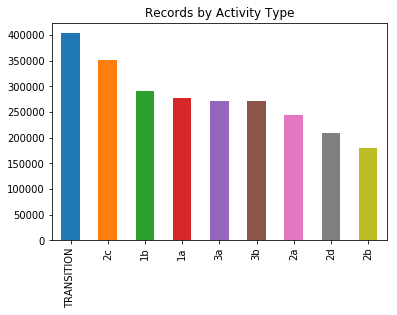

In [6]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(6, 4),align='center');

# Remove "TRANSITION"

In [7]:
indexes = df[df['Activity'] == 'TRANSITION'].index
df.drop(indexes, inplace=True)

In [8]:
print(df.count())
df.head()

Timestamp    2095566
Ax           2095566
Ay           2095566
Az           2095566
Gx           2095566
Gy           2095566
Gz           2095566
Mx           2095566
My           2095566
Mz           2095566
Activity     2095566
dtype: int64


,Timestamp,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,Activity
0,2019-07-15_104955:220,-0.466217,0.011688,-0.190125,0.003303,0.017582,0.009117,-44.560001,-17.250000,-0.56,2d
1,2019-07-15_104955:240,-0.466705,0.009125,-0.173370,0.004188,0.018772,0.011375,-44.560001,-17.250000,-0.56,2d
2,2019-07-15_104955:260,-0.465179,0.008636,-0.167267,0.004921,0.019566,0.011894,-44.560001,-16.559999,0.06,2d
3,2019-07-15_104955:280,-0.486023,0.008636,-0.146912,0.005348,0.020176,0.012718,-44.560001,-16.559999,0.06,2d
4,2019-07-15_104955:300,-0.464691,0.004059,-0.130646,0.006599,0.020298,0.012169,-44.560001,-16.559999,0.06,2d


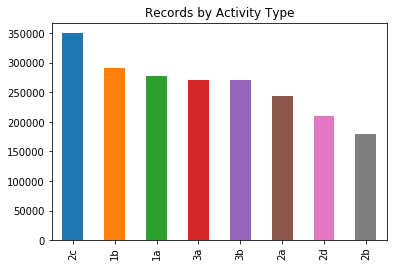

In [9]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(6, 4),align='center');

# Fit transform to make string type

In [10]:
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'].astype(str))

# Normalize the data

In [11]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

df['Ax'] = df['Ax'] / df['Ax'].max()
df['Ay'] = df['Ay'] / df['Ay'].max()
df['Az'] = df['Az'] / df['Az'].max()

df['Gx'] = df['Gx'] / df['Gx'].max()
df['Gy'] = df['Gy'] / df['Gy'].max()
df['Gz'] = df['Gz'] / df['Gz'].max()

df['Mx'] = df['Mx'] / df['Mx'].max()
df['My'] = df['My'] / df['My'].max()
df['Mz'] = df['Mz'] / df['Mz'].max()

# Round numbers
df = df.round({'Ax': 6, 'Ay': 6, 'Az': 6, 'Gx': 6, 'Gy': 6, 'Gz': 6, 'Mx': 6, 'My': 6, 'Mz': 6})

In [12]:
N_TIME_STEPS = 100
N_FEATURES = 9
step = 50
segments = []
labels = []


for i in range(0, len(df) - N_TIME_STEPS, step):
    Ax = df['Ax'].values[i: i + N_TIME_STEPS]
    Ay = df['Ay'].values[i: i + N_TIME_STEPS]
    Az = df['Az'].values[i: i + N_TIME_STEPS]
    
    Gx = df['Gx'].values[i: i + N_TIME_STEPS]
    Gy = df['Gy'].values[i: i + N_TIME_STEPS]
    Gz = df['Gz'].values[i: i + N_TIME_STEPS]
    
    Mx = df['Mx'].values[i: i + N_TIME_STEPS]
    My = df['My'].values[i: i + N_TIME_STEPS]
    Mz = df['Mz'].values[i: i + N_TIME_STEPS]
    
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([Ax, Ay, Az, Gx, Gy, Gz, Mx, My, Mz])
    labels.append(label)

In [13]:
reshaped_segments = np.asarray(segments, dtype= np.float64).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float64)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [15]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)
print('y_train values : ', y_train)

X_train :  (33528, 100, 9)
X_test :  (8382, 100, 9)
y_train :  (33528, 8)
y_test :  (8382, 8)
y_train values :  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [16]:
verbose = 1
epochs = 10
batch_size = 50

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  100
n_features :  9
n_outputs :  8


In [17]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
# fit network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 33528 samples, validate on 8382 samples
Epoch 1/10
33528/33528 [==============================] - 34s 1ms/step - loss: 0.4680 - acc: 0.8279 - val_loss: 0.3129 - val_acc: 0.9112
Epoch 2/10
33528/33528 [==============================] - 33s 974us/step - loss: 0.2388 - acc: 0.9193 - val_loss: 0.2205 - val_acc: 0.9456
Epoch 3/10
33528/33528 [==============================] - 33s 981us/step - loss: 0.1796 - acc: 0.9408 - val_loss: 0.1772 - val_acc: 0.9486
Epoch 4/10
33528/33528 [==============================] - 33s 978us/step - loss: 0.1456 - acc: 0.9509 - val_loss: 0.1664 - val_acc: 0.9476
Epoch 5/10
33528/33528 [==============================] - 33s 977us/step - loss: 0.1235 - acc: 0.9606 - val_loss: 0.1406 - val_acc: 0.9639
Epoch 6/10
33528/33528 [==============================] - 33s 972us/step - loss: 0.1080 - acc: 0.9652 - val_loss: 0.1138 - val_acc: 0.9722
Epoch 7/10
33528/33528 [==============================] - 33s 975us/step - loss: 0.0967 - acc: 0.9680 - val_loss: 0.120

# Confusion Matrix

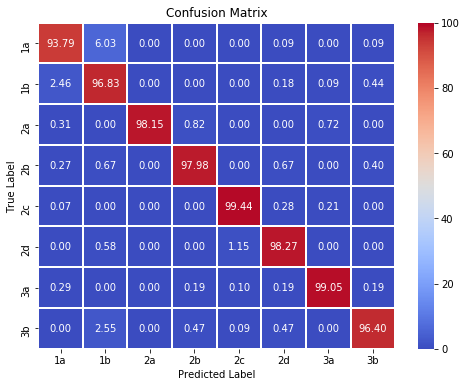

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1127
           1       0.91      0.97      0.94      1136
           2       1.00      0.98      0.99       973
           3       0.98      0.98      0.98       742
           4       0.99      0.99      0.99      1430
           5       0.98      0.98      0.98       866
           6       0.99      0.99      0.99      1051
           7       0.99      0.96      0.98      1057

   micro avg       0.97      0.97      0.97      8382
   macro avg       0.98      0.97      0.98      8382
weighted avg       0.98      0.97      0.98      8382



In [19]:

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = [ '1a', '1b', '2a', '2b', '2c', '2d', '3a', '3b']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
matrix = (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])*100
fmt = '.2f'
plt.figure(figsize=(8, 6))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels= LABELS,
            yticklabels= LABELS,
            annot=True,
            fmt=fmt,
           vmax = 100)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(max_y_test, max_y_pred_test))